In [1]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.0MB/s 
     |████████████████████████████████| 901kB 39.5MB/s 
     |████████████████████████████████| 3.3MB 55.0MB/s 


In [2]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
  
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

model = AutoModelForQuestionAnswering.from_pretrained("dbmdz/bert-base-turkish-cased")

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from

#1. Preparing The Data


##Extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json

def read_tquad(path):
    # open JSON file and load intro dictionary
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                # check if we need to be extracting from 'answers' or 'plausible_answers'
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa[access]:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

# execute our read SQuAD function for training and validation sets
train_contexts, train_questions, train_answers = read_tquad('/content/drive/MyDrive/turkish-nlp-qa-dataset-master/train-v0.1.json')
val_contexts, val_questions, val_answers = read_tquad('/content/drive/MyDrive/turkish-nlp-qa-dataset-master/dev-v0.1.json')

In [5]:
# Calculate the number of samples to include in each set.
train_size = len(train_contexts)
val_size = len(val_contexts)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,308 training samples
2,676 validation samples


In [ ]:
print(val_answers[12])

{'answer_start': '95', 'text': '1241'}


In [ ]:
print(train_questions[0])

el-Hasan b. Muhammed el-Vezzan isimli bilgin avrupa’da nasıl tanınmaktadır ?


In [ ]:
print(train_answers[0])

{'answer_start': '171', 'text': 'Afrikalı Leo'}


Our contexts and questions are simple strings — each corresponds to each other. The answer to each question can be found within the context.
The answers lists are slightly different in that each item is a dictionary where the answer is contained within 'text' — and the starting position of this answer within the context is also provided in 'answer_start'.
This is okay, but we need to train our model to find the start and end of our answer within the context — so we need to add an 'answer_end' value too:

In [6]:
def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = int(answer['answer_start']) ######## SEE THAT IN OUR DATASET 'answer_start' is a string, not a int. So cast it to int.
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            # this means the answer is off by 1-2 tokens
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n
            
# and apply the function to our two answer lists
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

##Encoding

In [7]:
MAX_LENGTH = 512

In [8]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True, max_length= MAX_LENGTH)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True, max_length= MAX_LENGTH)

In [9]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
train_encodings["token_type_ids"][0]

This concatenated version is stored within the input_ids attribute of our Encoding object. But, rather than the human-readable text — the data is stored as BERT-readable token IDs.
The tokenizer is great, but it doesn’t produce our answer start-end token positions. For that, we define a custom add_token_positions function:

In [10]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, int(answers[i]['answer_start']))) #Casting str 'answer_start' to int
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

          # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift position until found
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# apply function to our data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
train_encodings['start_positions'][0]

34

In [ ]:
train_encodings['end_positions'][0]

37

##Initializing the Dataset

In [11]:
import torch

class TquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# build datasets for both our training and validation sets
dataset = TquadDataset(train_encodings)
val_dataset = TquadDataset(val_encodings)

In [12]:
from torch.utils.data import random_split

# Create a 98-2 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.98 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, epoch_val = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,141 training samples
  167 validation samples


#2. Fine Tuning

In [13]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


##Data Loader & Optimizer

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
 
# For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# initialize data loader for training data
train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle = True # Select batches randomly
                         )

epoch_val_loader = DataLoader(epoch_val, 
                       batch_size = batch_size, 
                       sampler = SequentialSampler(epoch_val), # Pull out batches sequentially.
                      )

# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(),  
              lr = 4e-5, # args.learning_rate - default is 5e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
             )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

In [15]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

import gc
gc.collect()
torch.cuda.empty_cache()

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

##Training

In [88]:
from tqdm import tqdm

import gc

# to save some memory
gc.collect()
torch.cuda.empty_cache()

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy
training_stats = []
best_accuracy = 0

for epoch in range(1):

    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    # Reset the total loss for this epoch.
    total_train_loss = 0

    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()

        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        segment_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        
        # extract loss
        loss = outputs[0]
        total_train_loss += loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # Update the learning rate.
        scheduler.step()

        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
  
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our epoch validation set.
    # loop through batches
    print("")
    print("Running Validation...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_epoch_val_loss = 0
    acc = []

    for batch in val_loader:
      # we don't need to calculate gradients as we're not training
      with torch.no_grad():
          # pull batched items from loader
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          segment_ids = batch['token_type_ids'].to(device)
           
          # we will use true positions for accuracy calc 
          start_true = batch['start_positions'].to(device)
          end_true = batch['end_positions'].to(device)

          # make predictions
          outputs = model(input_ids, 
                          attention_mask=attention_mask,
                          token_type_ids = segment_ids)

          # extract loss
          total_epoch_val_loss += outputs[0]
            
          # pull prediction tensors out and argmax to get predicted tokens
          start_pred = torch.argmax(outputs['start_logits'], dim=1)
          end_pred = torch.argmax(outputs['end_logits'], dim=1)

          # calculate accuracy for both and append to accuracy list
          acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
          acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    
    # calculate average accuracy in total
    avg_val_accuracy = sum(acc)/len(acc)      
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_epoch_val_loss / len(epoch_val_loader)
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )

    # save the best model
    if avg_val_accuracy > best_accuracy:
        model_path = "models/tquad-custom-best"
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

   
   

Epoch 1: 100%|██████████| 1018/1018 [15:08<00:00,  1.12it/s, loss=0.148]



Running Validation...


RuntimeError: ignored

##Save the Model

In [ ]:
model_path = "models/tquad-custom"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

#Use following code to load the model
"""
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

"""

'\nmodel = AutoModel.from_pretrained(model_path)\ntokenizer = AutoTokenizer.from_pretrained(model_path)\n\n'

In [ ]:
!zip -r ./models.zip ./models/

updating: models/ (stored 0%)
  adding: models/tquad-custom3/ (stored 0%)
  adding: models/tquad-custom3/tokenizer_config.json (deflated 34%)
  adding: models/tquad-custom3/pytorch_model.bin (deflated 7%)
  adding: models/tquad-custom3/vocab.txt (deflated 53%)
  adding: models/tquad-custom3/special_tokens_map.json (deflated 40%)
  adding: models/tquad-custom3/config.json (deflated 47%)


In [ ]:
from google.colab import files
files.download("./models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3. Measuring Performance
To extract the start-end token range from our model, we can access the start_logits and end_logits tensors and perform an argmax function like so:

In [52]:
start_pred = torch.argmax(outputs['start_logits'], dim=1)
end_pred = torch.argmax(outputs['end_logits'], dim=1)

To calculate the EM of each batch, we take the sum of the number of matches per batch — and divide by the total. We do this with PyTorch like so:

In [53]:
acc = ( (start_pred == start_positions).sum() / len(start_pred) ).item()

## EM

In [89]:
# switch model out of training mode
model.eval()
# initialize validation set data loader
val_loader = DataLoader(val_dataset,
                        batch_size=16,
                        shuffle = False)
# initialize list to store accuracies
acc = []

# Lists to store locations
start_positions = []
end_positions = []

# Tracking variables 
pred_start = []
pred_end = []

# loop through batches
for batch in val_loader:
   
    # we don't need to calculate gradients as we're not training
    with torch.no_grad():
        # pull batched items from loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        segment_ids = batch['token_type_ids'].to(device)

        # we will use true positions for accuracy calc
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        tokens = tokenizer.batch_decode(batch['input_ids'])

        start_positions.append(start_true)
        end_positions.append(end_true)

        # make predictions
        outputs = model(input_ids, 
                        attention_mask=attention_mask, 
                        token_type_ids = segment_ids)

        # pull prediction tensors out and argmax to get predicted tokens
        start_pred = torch.argmax(outputs['start_logits'], axis=1)
        end_pred = torch.argmax(outputs['end_logits'], axis=1)

        pred_start.append(start_pred)
        pred_end.append(end_pred)

        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())



# calculate average accuracy in total
acc = sum(acc)/len(acc)

In [90]:
acc

0.6662946428571429

In [91]:
start_positions[1]

tensor([ 44,  44,   1,   1,   1,  90,  90,  90,  90,  90,  90, 110, 110, 110,
        122, 122], device='cuda:0')

In [92]:
end_positions[1]

tensor([ 53,  53,   2,   2,   2,  95,  95,  95,  95,  95,  95, 115, 115, 115,
        131, 131], device='cuda:0')

In [93]:
pred_start[1]

tensor([ 44,  44,  74,  74,  74,  89,  89,  89,  90,  90,  90, 110, 110, 110,
        122, 122], device='cuda:0')

In [94]:
pred_end[1]

tensor([ 53,  53,  82,  82,  82,  98,  98,  98,  95,  95,  95, 115, 115, 115,
        133, 133], device='cuda:0')

This accuracy seems a bit low. However, we can see that it predicts start and end points very closely if we look deeply.

In [95]:
print("T/F\tstart\tend\n")
for i in range(len(start_true)-1):
    print(f"true\t{start_true[i]}\t{end_true[i]}\n"
          f"pred\t{start_pred[i]}\t{end_pred[i]}\n")

T/F	start	end

true	212	213
pred	212	213

true	11	16
pred	11	16

true	11	16
pred	11	16



##F1

In [96]:
# Combine the results across the batches.
pred_start = [item for sublist in pred_start for item in sublist]
pred_end = [item for sublist in pred_end for item in sublist]

start_positions = [item for sublist in start_positions for item in sublist]
end_positions = [item for sublist in end_positions for item in sublist]

In [97]:
pred_start[0:6]

[tensor(74, device='cuda:0'),
 tensor(74, device='cuda:0'),
 tensor(74, device='cuda:0'),
 tensor(20, device='cuda:0'),
 tensor(20, device='cuda:0'),
 tensor(20, device='cuda:0')]

In [98]:
len(start_positions)

2676

In [99]:
len(pred_start)

2676

In [100]:
for i in range(0, 30, 3):
  print(pred_start[i])

tensor(74, device='cuda:0')
tensor(20, device='cuda:0')
tensor(20, device='cuda:0')
tensor(18, device='cuda:0')
tensor(27, device='cuda:0')
tensor(44, device='cuda:0')
tensor(74, device='cuda:0')
tensor(89, device='cuda:0')
tensor(90, device='cuda:0')
tensor(110, device='cuda:0')


In [101]:
import numpy as np

# initialize list to store f1 scores
f1s = []

for i in range(0, len(start_positions), 3):
  # Expand the start and end indeces into sequences of indeces stored as sets.
  # For example, if pred_start = 137 and pred_end = 140, then
  # pred_span = {137, 138, 139, 140}
  pred_span = set(range(pred_start[i], pred_end[i] + 1))

  # Expand answer into a range, as above
  true_span = set(range(start_positions[i], end_positions[i] + 1))   


  # Use the `intersection` function from Python `set` to get the set of 
  # indeces occurring in both spans. Take the length of this resulting set
  # as the number of overlapping indeces between the two spans.
  num_same = len(pred_span.intersection(true_span))     

   # If there's no overlap, then the F1 score is 0 for this sample.
  if num_same == 0:
    f1s.append(0)
    continue
 
  # Precision - How many tokens overlap relative to the total number of tokens
  #             in the predicted span? If the model predicts too large of a 
  #             span, it has bad precision.      
  precision = float(num_same) / float(len(pred_span))
    
  # Recall - How many of the correct tokens made it into the predicted span?
  #          A model could have perfect recall if it just predicted the entire
  #          paragraph as the answer :).    
  recall = float(num_same) / float(len(true_span))

  # F1 - Does the model have both good precision and good recall?
  f1 = (2 * precision * recall) / (precision + recall)

  # Store the score.
  f1s.append(f1)

print('Average F1 Score: {:.3f}'.format(np.mean(f1s)))  

Average F1 Score: 0.708


##Manual Experiments

In [102]:
metin = """ Altın Gün, Hollanda'nın Amsterdam şehrinde kurulan, Hollandalı ve Türk üyelerden oluşan bir Anadolu rock ve saykodelik folk grubudur """

soru = """ altın gün nerede kurulmuştur? """

In [103]:
encoded_dict = tokenizer(soru,
                         metin,
                         truncation=True, padding=True, 
                         max_length= MAX_LENGTH,
                         return_tensors = 'pt')
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [104]:
# Retrieve the encoded sequence.
input_ids = encoded_dict['input_ids']

# its attention mask (simply differentiates padding from non-padding).
attention_masks = encoded_dict['attention_mask'] 

# Store the segment IDs, which indicate which tokens belong to the question
# vs. the context.
segment_ids = encoded_dict['token_type_ids']

# Copy these to the GPU.
b_input_ids = input_ids.to(device)
b_attn_masks = attention_masks.to(device)
b_seg_ids = segment_ids.to(device)

# Telling the model not to compute or store the compute graph, saving memory 
# and speeding up prediction
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, 
                   attention_mask=b_attn_masks,
                   token_type_ids=b_seg_ids,
                   return_dict=True)
                    

# Move logits to CPU.
start_logits = outputs.start_logits.detach().cpu().numpy()
end_logits = outputs.end_logits.detach().cpu().numpy()

# Find the tokens with the highest `start` and `end` scores.
answer_start = np.argmax(start_logits, axis=1)
answer_end = np.argmax(end_logits, axis=1)

In [105]:
input_ids

tensor([[    2,  5573,  2173,  4454, 13251,    35,     3,  6472,  2926,    16,
          7966,    11,  2732, 24827, 13764,  6450,    16, 23645,  1992,  2178,
         10550,  2025,  4455,  1996,  4223, 17158,  1992,  2286,  6797, 13919,
         17627,  1007,  6861,  2524,     3]])

In [106]:
answer_start

array([10])

In [107]:
answer_end

array([14])

In [108]:
for_result = tokenizer.encode(soru, 
                 metin,
                 add_special_tokens = True)

In [109]:
answer_tokens = tokenizer.convert_ids_to_tokens(for_result[int(answer_start):int(answer_end)+1], skip_special_tokens=True)

answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)

print("Cevap : ",answer_tokens_to_string)

Cevap :  Hollanda'nın Amsterdam şehrinde


#4. Visualization

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [111]:
start_scores = outputs.start_logits
end_scores = outputs.end_logits

s_scores = start_scores.cpu().detach().numpy().flatten()
e_scores = end_scores.cpu().detach().numpy().flatten()

In [112]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens

['[CLS]',
 'altın',
 'gün',
 'nerede',
 'kurulmuştur',
 '?',
 '[SEP]',
 'Altın',
 'Gün',
 ',',
 'Hollanda',
 "'",
 'nın',
 'Amsterdam',
 'şehrinde',
 'kurulan',
 ',',
 'Hollandalı',
 've',
 'Türk',
 'üyeler',
 '##den',
 'oluşan',
 'bir',
 'Anadolu',
 'rock',
 've',
 'say',
 '##ko',
 '##delik',
 'fol',
 '##k',
 'grubu',
 '##dur',
 '[SEP]']

In [113]:
# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
# For each token and its id...
for token, id in zip(tokens, input_ids[0]):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

[CLS]             2
altın         5,573
gün           2,173
nerede        4,454
kurulmuştur  13,251
?                35

[SEP]             3

Altın         6,472
Gün           2,926
,                16
Hollanda      7,966
'                11
nın           2,732
Amsterdam    24,827
şehrinde     13,764
kurulan       6,450
,                16
Hollandalı   23,645
ve            1,992
Türk          2,178
üyeler       10,550
##den         2,025
oluşan        4,455
bir           1,996
Anadolu       4,223
rock         17,158
ve            1,992
say           2,286
##ko          6,797
##delik      13,919
fol          17,627
##k           1,007
grubu         6,861
##dur         2,524

[SEP]             3



In [114]:
token_labels

['[CLS] -  0',
 'altın -  1',
 'gün -  2',
 'nerede -  3',
 'kurulmuştur -  4',
 '? -  5',
 '[SEP] -  6',
 'Altın -  7',
 'Gün -  8',
 ', -  9',
 'Hollanda - 10',
 "' - 11",
 'nın - 12',
 'Amsterdam - 13',
 'şehrinde - 14',
 'kurulan - 15',
 ', - 16',
 'Hollandalı - 17',
 've - 18',
 'Türk - 19',
 'üyeler - 20',
 '##den - 21',
 'oluşan - 22',
 'bir - 23',
 'Anadolu - 24',
 'rock - 25',
 've - 26',
 'say - 27',
 '##ko - 28',
 '##delik - 29',
 'fol - 30',
 '##k - 31',
 'grubu - 32',
 '##dur - 33',
 '[SEP] - 34']

In [115]:
s_scores

array([-2.600561 , -9.664235 , -9.561955 , -8.7510605, -8.865706 ,
       -8.871937 , -6.663709 ,  2.935118 , -6.795193 , -3.96241  ,
       12.856486 ,  2.1808896,  3.4450727,  7.9500246,  2.1420457,
       -1.9403175, -3.8343148, -0.4981613, -6.210924 , -2.7077572,
       -4.2875643, -7.3982205, -5.809592 , -1.9532677, -0.8797266,
       -5.655018 , -7.623312 , -5.3439207, -7.8837595, -7.6028337,
       -7.3082576, -8.515182 , -7.0040183, -6.3249803, -6.702182 ],
      dtype=float32)

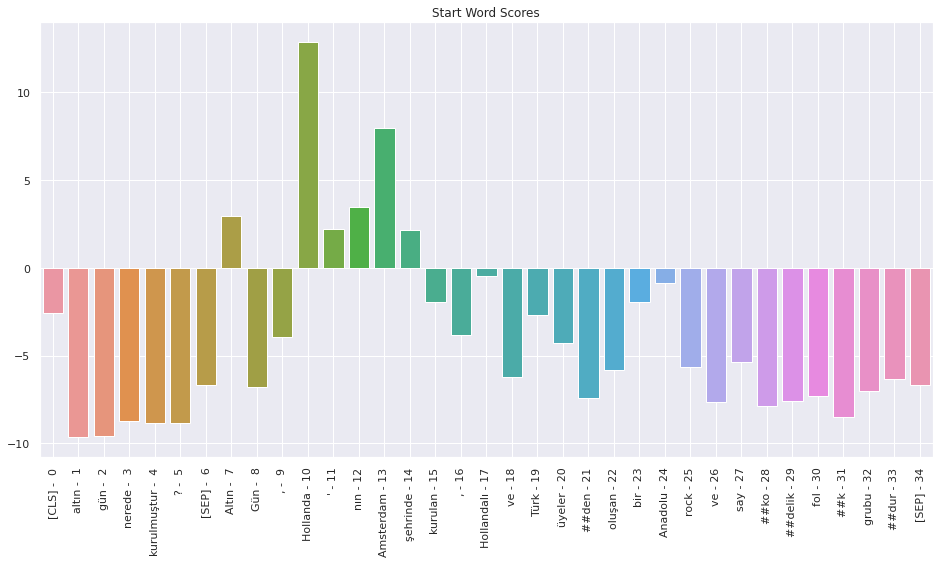

In [116]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

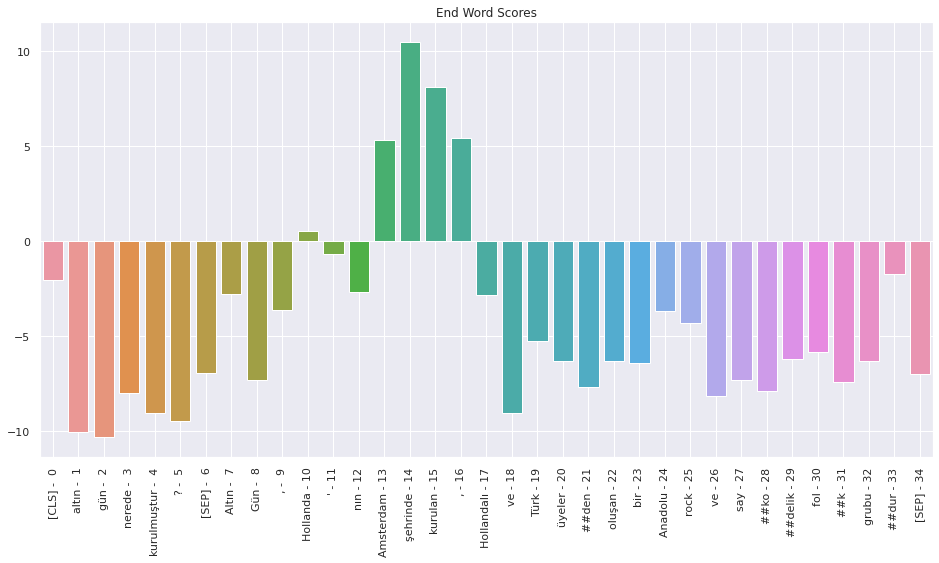

In [117]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [118]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)

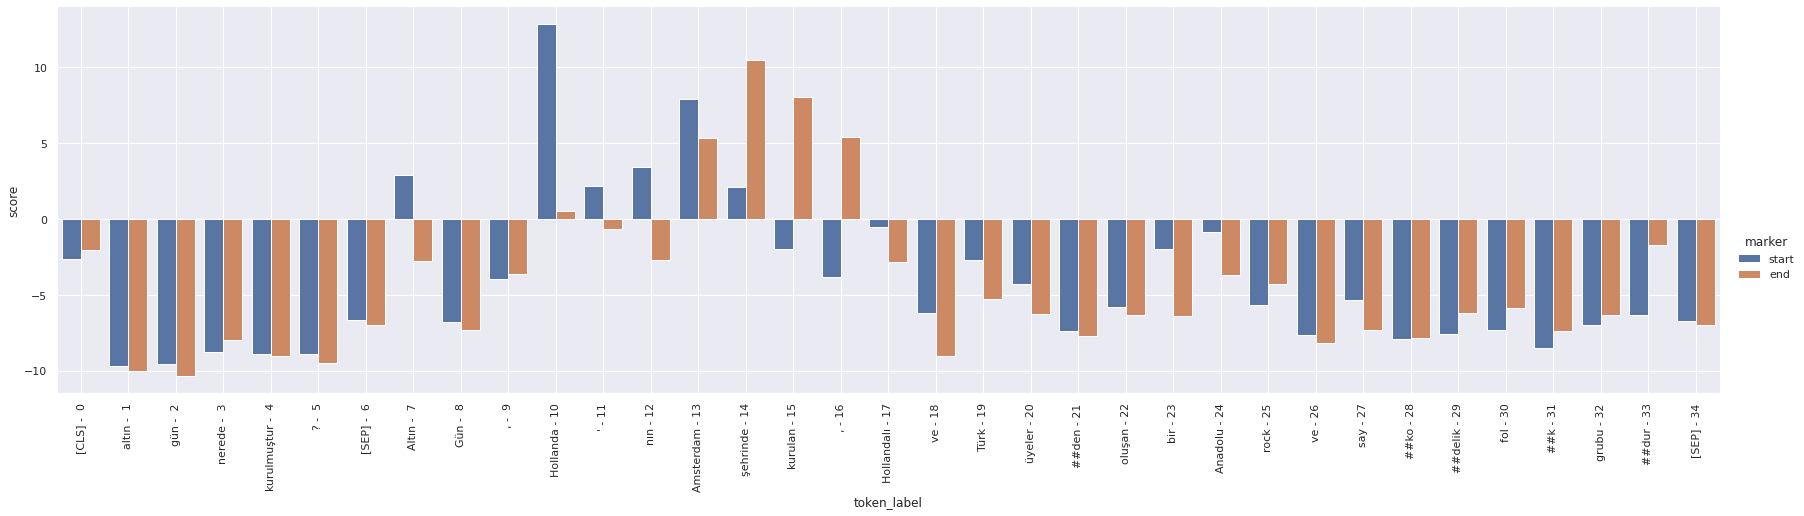

In [119]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)